# **Question 1** - Diffused-Limit Aggregation

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from celluloid import Camera
from IPython.display import HTML
import os

def animate_random_walk(solix, soliy, liqx = None, liqy = None, num_particles = 50, grid_size = 200, filename = None):
    matplotlib.use('qt5agg')
    def save_gif(fn):
        # Check if the file exists
        if os.path.isfile(f"{fn}.gif"):
            pass
        else:
            anim.save(f'{filename}.gif', writer='Pillow')

    if filename is None:
        if liqx is not None and liqy is not None:
            filename = f"Crystallisation_{num_particles}_Particles_{grid_size}_Grid"
        else:
            filename = f"Random_Walk_{num_particles}_Particles_{grid_size}_Grid"

    fig = plt.figure()
    camera = Camera(fig)
        
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)

    if liqx is not None and liqy is not None:

        for a, b, x, y in zip(liqx, liqy, solix, soliy):
            plt.title(f"N = {num_particles} Particles, Grid Size = {grid_size}x{grid_size}")
            plt.scatter(x, y, s = 1, color = 'dodgerblue', marker = 's')
            plt.scatter(a, b, s = 1, color = 'black', marker = 's')
            camera.snap()

        anim = camera.animate(blit=True)
        save_gif(filename)
    else:
        N = len(solix[0])
        c = ['#%06X'.lower() % np.random.randint(0, 0xFFFFFF) for i in range(N)]

        for x, y in zip(solix, soliy):
            plt.title(f"N = {num_particles} Particles, Grid Size = {grid_size}x{grid_size}")
            plt.scatter(x, y, s = 1, color = c, marker = 's')
            camera.snap()

        anim = camera.animate(blit=True)
        save_gif(filename)

## **a. Random Walk**

Model a random walk of $N = 10^4$ particles on an $n \times n$ grid. At each timestep, a particle can either stay still or move to one of it's 8 neighbouring cells.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def random_walk(time_steps, N = 500, n = 200, plot = True):
    '''Random Walk in 2D
    Inputs:
    dt: number of time steps
    N: Number of particles
    n: size of the grid
    plot: whether to plot the trajectories or not

    Outputs:
    Returns the distance travelled per particle
    '''

    # Create nxn matrix
    grid = np.zeros((n,)*2)


    # Randomly place particles in the grid
    x = np.random.randint(0, n, size=N)
    y = np.random.randint(0, n, size=N)

    # Store the initial positions
    x_history = [x]
    y_history = [y]

    # Fill the grid with 1s where the particles are
    for i in range(N):
        grid[x[i]][y[i]] = 1

    for dt in range(time_steps):
        x = x + np.random.randint(-1, 2, size=N)
        y = y + np.random.randint(-1, 2, size=N)

        # Periodic Boundary Conditions
        x = np.mod(x, n)
        y = np.mod(y, n)

        x_history += [x]
        y_history += [y]

        # New Grid
        grid = np.zeros((n,)*2)
        for i in range(N):
            grid[x[i]][y[i]] = 1

    if plot:
        animate_random_walk(x_history, y_history, num_particles = N, grid_size = n)

    dist = np.sqrt((x_history[-1] - x_history[0])**2 + (y_history[-1] - y_history[0])**2)

    return dist

random_walk(100, N = 100);

![SegmentLocal](Random_Walk_100_Particles_200_Grid.gif "segment")

In [5]:
time_steps = [a for a in range(1, 1000, 10)]
dist = []
for dt in time_steps:
    dist.append(np.mean(random_walk(dt, N = int(1E4), n = 200, plot = False)))

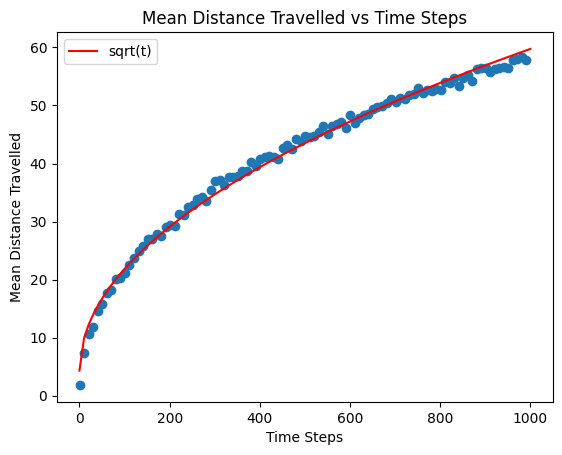

In [13]:
from scipy.optimize import curve_fit
%matplotlib inline
plot_x = np.linspace(0, 1000, 100)

# Fit a sqrt(t) curve to the time_steps data
sqrt_finc = lambda x, a, b: a*np.sqrt(x) + b
a, b = curve_fit(sqrt_finc, time_steps, dist)[0]
sqrt_time = a*np.sqrt(plot_x) + b


plt.figure(3)
plt.scatter(time_steps, dist)
plt.plot(plot_x, sqrt_time, color = 'red', label = "sqrt(t)")
plt.title("Mean Distance Travelled vs Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Mean Distance Travelled")
plt.legend()
plt.show()

We can see here that the mean distance travelled very well fits a $1/\sqrt{x}$ model. This is congruent with Einstein's argument that the displacement of a particle undergoing Brownian motion is proportional to the square root of time.

## **b. Solid Seed**

Now, create a solid seed in the centre of the grid. Anytime a randomly walking particle finds itself next to the seed, that particle joins the solid seed. Evolve this random walk until 80% of the randomly walking particles have joined the solid.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    

def adjacent_solid(liquid_x, liquid_y, solid_x, solid_y):
    '''Checks if the particle is adjacent to the solid object
    Inputs:
    x: x array of the particle positions
    y: y array of the particle positions
    solid_x: x positions of the solid object
    solid_y: y positions of the solid object

    Outputs:
    Returns True if the particle is inside the solid object, False otherwise
    '''
    adj_x = [] # Stores the values from the x array
    adj_y = [] # Stores the values from the y array
    adj_indices = np.array([], dtype = int) # Stores the indices of the adjacent particles

    # Use np.where to search for adjacent particles
    for i in range(len(solid_y)):
        x = solid_x[i]
        y = solid_y[i]

        temp_adj_x_indices = []
        temp_adj_y_indices = []

        # Get indices of x or y that are adjacent to the solid object
        temp_adj_x_indices = list(np.where(liquid_x == x + 1)[0]) + list(np.where(liquid_x == x)[0]) + list(np.where(liquid_x == x - 1)[0])
        temp_adj_y_indices = list(np.where(liquid_y == y + 1)[0]) + list(np.where(liquid_y == y)[0])  + list(np.where(liquid_y == y - 1)[0])

        # Find common elements between temp_adj_x_indices and temp_adj_y_indices
        common_indices = np.intersect1d(temp_adj_x_indices, temp_adj_y_indices)
        if len(common_indices) > 0 and np.intersect1d(adj_indices, common_indices).size == 0:
            adj_indices = np.concatenate((adj_indices, common_indices.copy()), axis = None)

        for el in common_indices:
            common_x = liquid_x[el]
            common_y = liquid_y[el]

            if common_x not in adj_x and common_y not in adj_y:
                adj_x.append(common_x.copy())
                adj_y.append(common_y.copy())

    
    if len(adj_indices) > 0:
        if len(adj_x) == len(adj_y):
            # Add adjacent particles to the solid list
            solid_x += adj_x.copy()
            solid_y += adj_y.copy()
            # Remove adjacent particles from the liquid list
            liquid_x = np.delete(liquid_x, adj_indices)
            liquid_y = np.delete(liquid_y, adj_indices)

        else:
            print(adj_x, adj_y)
            print("Error: adj_x and adj_y are not the same length. Cant add to the solid list/remove from the liquid list")
    # else:
    #     print(f"No adjacent particles: {adj_indices}")

    return liquid_x, liquid_y, solid_x, solid_y
    
def random_walk_solid(N = 500, n = 200, plot = True, plot_steps = 50, lim = 1000):
    '''Random Walk in 2D
    Inputs:
    dt: number of time steps
    N: Number of particles
    n: size of the grid
    plot: whether to plot the trajectories or not

    Outputs:
    Returns the distance travelled per particle
    '''

    time_steps = 0

    # Create nxn matrix
    grid = np.zeros((n,)*2)

    # Place a solid object in the middle (9 particles)
    solid_x = [] # Keep track of the indicies of the solid object
    solid_y = []

    for i in range(-1, 2):
        for j in range(-1, 2):
            solid_x.append(n//2 + i)
            solid_y.append(n//2 + j)
            grid[n//2 + i][n//2 + j] = 1


    
    # Randomly place particles in the grid
    x = np.random.randint(0, n-1, size=N)
    y = np.random.randint(0, n-1, size=N)

    x_history = [x.copy()]
    y_history = [y.copy()]

    solid_x_history = [solid_x.copy()]
    solid_y_history = [solid_y.copy()]

    # Check if the particles are in the solid object
    delete_indices = np.where(np.isin(x, solid_x) & np.isin(y, solid_y))[0]
    
    # Remove from particle list
    x = np.delete(x, delete_indices)
    y = np.delete(y, delete_indices)
    
    # Check if any initial positions are adjacent to the solid object
    x, y, solid_x, solid_y = adjacent_solid(x, y, solid_x, solid_y)

    # Store the initial positions
    x_history.append(x.copy())
    y_history.append(y.copy())

    solid_x_history.append(solid_x.copy())
    solid_y_history.append(solid_y.copy())


    for i in range(0, len(x)):
        grid[x[i]][y[i]] = 1

    while len(x)/N > 0.8 and time_steps < lim:
        time_steps += 1
        x = x + np.random.randint(-1, 2, size=len(x))
        y = y + np.random.randint(-1, 2, size=len(y))

        # Wrap around
        x = np.mod(x, n)
        y = np.mod(y, n)

        # Check for adjacency
        x, y, solid_x, solid_y = adjacent_solid(x, y, solid_x, solid_y)

        # Store the positions
        x_history.append(x.copy())
        y_history.append(y.copy())

        solid_x_history.append(solid_x.copy())
        solid_y_history.append(solid_y.copy())

        # New Grid
        grid = np.zeros((n,)*2)
        for i in range(0, len(x)):
            grid[x[i]][y[i]] = 1

    if plot:
        animate_random_walk(solid_x_history, solid_y_history, x_history, y_history, num_particles = N, grid_size = n)

    print(f"Took {time_steps} time steps to crystallise beyond {len(x)/N*100:.1f}% with {N} particles and a grid size of {n}x{n}")
    return solid_x_history, solid_y_history, x_history, y_history, time_steps


In [10]:
num_liquid_particles = 50
grid_size = 50
solid_x_history, solid_y_history, x_hist, y_hist, time_steps = random_walk_solid(N = num_liquid_particles, n = grid_size, plot = True, plot_steps = 50)

MovieWriter Pillow unavailable; using Pillow instead.


Took 490 time steps to crystallise beyond 80.0% with 50 particles and a grid size of 50x50


![SegmentLocal](Crystallisation_50_Particles_50_Grid.gif "segment")

With N = $10^4$ particles in a 200x200 grid, how many time steps until the 80% of the liquid particles have solidified?

In [11]:
solid_x_history, solid_y_history, x_hist, y_hist, time_steps = random_walk_solid(N = int(1E4), n = 200, plot = True, plot_steps = 100, lim = 1000)

MovieWriter Pillow unavailable; using Pillow instead.


Took 238 time steps to crystallise beyond 79.9% with 10000 particles and a grid size of 200x200


![SegmentLocal](Crystallisation_10000_Particles_200_Grid.gif "segment")

## **c. $N_{solid}$ Varying with Time**

Plot the number of solid particles against time.

In [5]:
solid_x_history, solid_y_history, x_hist, y_hist, time_steps = random_walk_solid(N = int(1E4), n = 200, plot = False, plot_steps = 100, lim = 1000)

Took 217 time steps to crystallise beyond 80.0% with 10000 particles and a grid size of 200x200


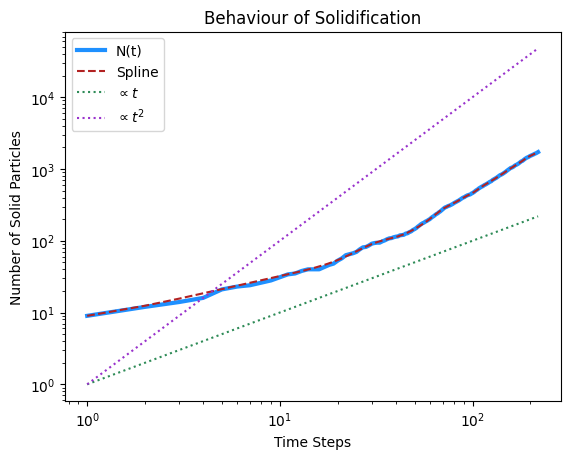

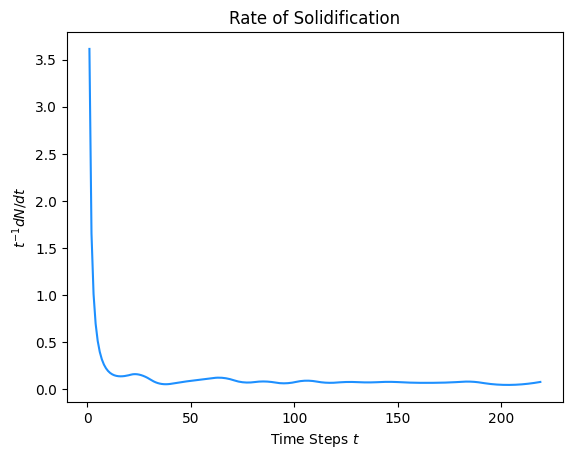

In [33]:
num_solid_particles = np.array([len(x) for x in solid_x_history])
time_steps_list = np.array([i for i in range(1, len(num_solid_particles) + 1)])

import scipy.interpolate

# Construct a spline of N(t)
spline = scipy.interpolate.CubicSpline(time_steps_list[::10], num_solid_particles[::10])

# Plot N(t) and the spline
plt.figure(1)
plt.plot(time_steps_list, num_solid_particles, linewidth = 3, color = 'dodgerblue', label = "N(t)")
plt.plot(time_steps_list, spline(time_steps_list), color = 'firebrick', label = "Spline", linestyle = '--')
plt.plot(time_steps_list, time_steps_list, color = "seagreen", label = "$\propto t$", linestyle = ':')
plt.plot(time_steps_list, time_steps_list**2, color = "darkorchid", label = "$\propto t^2$", linestyle = ':')
plt.title("Behaviour of Solidification")
plt.ylabel("Number of Solid Particles")
plt.xlabel("Time Steps")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# Plot dN/dt * 1/t
plt.figure(2)
plt.plot(time_steps_list, spline(time_steps_list, 1)/time_steps_list, color = 'dodgerblue', label = "dN/dt")
plt.xlabel("Time Steps $t$")
plt.ylabel("$t^{-1} dN/dt$")
plt.title("Rate of Solidification")
plt.show()

When there is a low density of liquid particles, the growth of the crystalline area is limited by the rate at which the particles can walk to a position adjacent to a crystal. This time, when the crystal reaches radius $r$ is given by the diffusion time corresponding to that distance:
$$ N \propto r2 \propto (\sqrt{t})^2 \propto t$$

or, where $\frac{dN}{dt}$ is a constant. This can be seen in the first plot where the curve of the blue $ N(t)$ line roughly follows the green $\propto t$ line.

In the higher $ N(t)$ areas of the first plot, we can see that it does not fit the green line very well. In this regime, the growth is proportional to the area available for the particles to solidify onto; that is, it is proportional to the "surface area" of the crystal:
$$\frac{dN}{dt} \propto r \propto N^{1/2} \rightarrow N^{1/2} \propto t \rightarrow N \propto t^{2} $$
This scaling with $t^2$ agrees well with the red line in the first plot, and in the second plot where the curve follows a roughly constant line in the non-zero regime.

# **Question 2** - Ising Model

The Ising model is a simple model of a ferromagnetic material in which a lattice of spins interact via nearest-neighbour interactions. In 2D, we have a square lattice with $n \times n = N$ lattice sites on which the spins sit. Each spin can be either up (s = +1) or down (s = -1), and the total energy of the system is $$ E = -\sum_{nn} s_is_j$$
where "nn" in the sum indicates that the sum is over nearest-neighbour pairs. Any given spin interact only withg the spins that are immediately up, down, left, and right from its location. We can see that the energy will be minimised when neighbouring spins are aligned. For any given configuration of spins, the total magnetisation is $$M = \sum_i s_i$$

At temperature T, the probability that the system is in a configuration with energy E is given by the Boltzmann distribution: $$Prob(E) \propto \exp(-E/k_BT)$$

To calculate the magnetisation at a given temperature, we need to sample the possible configurations from this probability distribution and then we can average over them to find the mean magnetisation $<M>$ as a function of temperature. Since energy $E$ depends on values of $N$ spins $\{s_i\}$, we are dealing with an N-dimensional parameter space (with $2^N$ possible sample points), and so this is an example where Monte Carlo methods are needed to sample from the probability distribution.

## **a. Generate a Sample of Configurations**

Use the Metropolis-Hastings algorithm to generate a sample of configurations $\{s_i\}$ from the Boltzmann distribution.

In [108]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42) # Random number generator

# Perform the Iterations
def metropolis_hastings(n = 30, num_steps = int(10**5), temperature = 0.65, plot = True):
    ''' Metropolis-Hastings Algorithm
    Inputs:
    n: size of the lattice
    num_steps: number of iterations
    temperature: temperature of the system
    plot: whether to plot the magnetisation per iteration or not

    Outputs:
    Returns the last 80% of magnetisation values
    '''
    numspins = n*n

    lattice = np.ones(numspins) # Initialise the lattice

    magnetisations = np.zeros(num_steps)
    magnetisations[0] = np.sum(lattice)/(numspins) # Store the initial magnetisation

    rand_nums = rng.uniform(size = num_steps) # Generate random numbers  in advance to save processing time

    # Metropolis-Hastings sampling
    for step in range(num_steps - 1):

        i = rng.integers(numspins) # Pick a random spin
        dE = 2*lattice[i] * (lattice[i - 1] + lattice[(i + 1) % numspins] + lattice[(i - n)] + lattice[(i + n) % numspins]) # Calculate the change in energy

        # Attempt Flip
        if rand_nums[step] < np.exp(-dE/temperature):
            lattice[i] = -lattice[i]

        # Store the magnetisation
        magnetisations[step + 1] = np.sum(lattice)/(numspins)
    
    if plot:
        # Plot the magnetisation values
        plt.figure(1)
        plt.plot(M[int(num_steps/5):], linewidth=0.75) # Remove the first 20% (burn-in period)
        plt.xlabel("Iterations")
        plt.ylabel("Magnetisation")
        plt.title(f"Magnetisation per Iteration at (T = {temperature}K)")
        plt.show()

    
    return magnetisations[int(num_steps/5):]

## **b. M vs T**

Make a plot of the Magnetisation chains for different temperatures in the range $k_BT$ = 1 to 4.

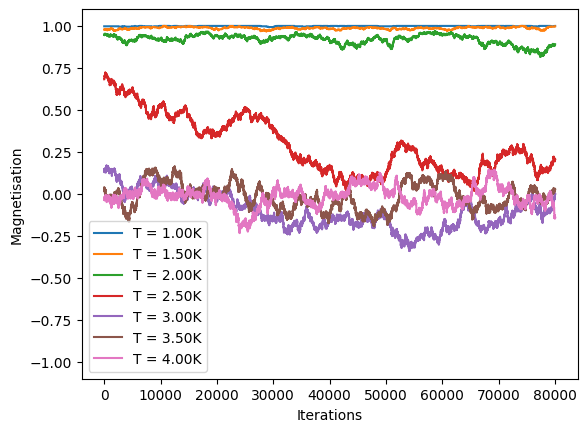

In [109]:
temp_list = np.arange(1.0, 4.05, 0.05) # Range of kbT values

mean_mags = np.zeros_like(temp_list) # Store the mean magnetisation
var_mags = np.zeros_like(temp_list) # Store the susceptibility

plt.figure(1)

for i, T in enumerate(temp_list):
    mag_array = metropolis_hastings(temperature = T, plot = False)
    mean_mags[i] = np.mean(np.abs(mag_array))
    var_mags[i] = np.var(mag_array)

    if(abs(np.floor(2*T) - (2*T)) < 1E-5):
        t = np.arange(len(mag_array))
        plt.plot(t, mag_array, label = f"T = {T:.2f}K")

plt.ylim(-1.1, 1.1)
plt.xlabel("Iterations")
plt.ylabel("Magnetisation")
plt.legend(loc = 'lower left')
plt.show()

## **c. Characterization**

Plot the mean Magnetisation and the variance as a function of temperature.

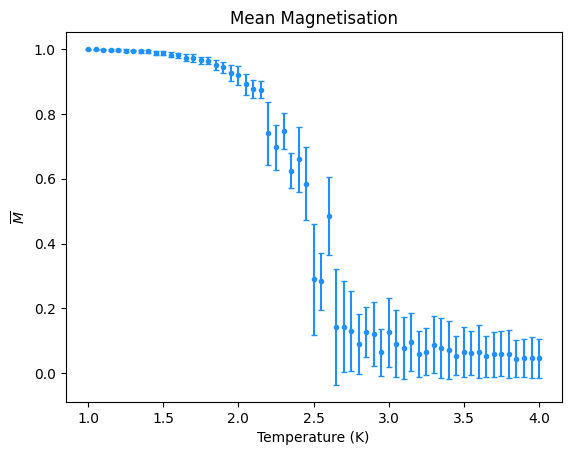

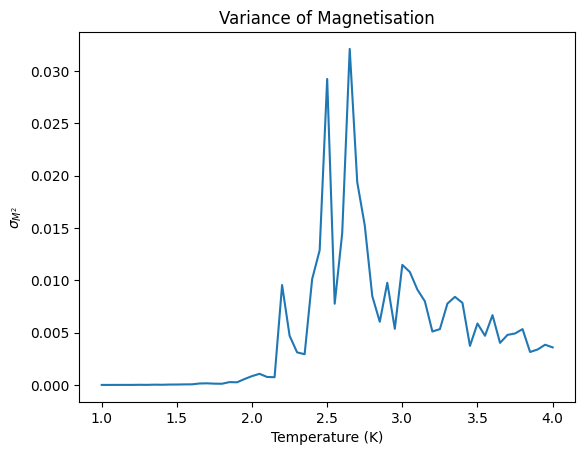

In [111]:
plt.figure(2)
plt.errorbar(temp_list, mean_mags, yerr = np.sqrt(var_mags), fmt = '.', capsize = 2, color = 'dodgerblue')
plt.xlabel("Temperature (K)")
plt.ylabel("$\overline{M}$")
plt.title("Mean Magnetisation")
plt.show()

plt.figure(3)
plt.plot(temp_list, var_mags)
plt.xlabel("Temperature (K)")
plt.ylabel("$\sigma_{M^2}$")
plt.title("Variance of Magnetisation")
plt.show()

There is clearly a phase transfer at around 2.25 K, which is evidenced by the sharp change in magnetisation.